In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

# What's that type?

**Can we predict the type of a pokemon?**

A pokemon's type is representatitve of the elemental properties of the pokemon. Pokemon have can have one or two types and are represented in the data as features `Type_1` and `Type_2`. In most cases a Pokemon with two types have their more representative type listed first, though this is not only the case. For this analysis we will see if there is predictive power in the pokemon's other features that could indicate to us its type.

In [2]:
df_master = pd.read_csv('../data/pokemon_alopez247.csv')
df_master = df_master.set_index('Number')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

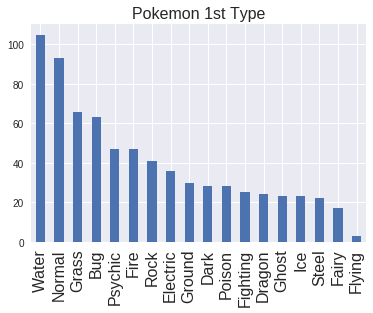

In [3]:
df_master['Type_1'].value_counts().plot( kind='bar')
plt.title('Pokemon 1st Type', fontsize=16)
plt.xticks( fontsize=16, rotation=90)

## Data Preparation

We will use the following features to predict pokemon type:

- Battle Attributes: `Total`, `HP`, `Attack`, `Defense`, `Sp_Atk`, `Sp_Def`, `Speed`
- Physical Attributes: `Color`, `hasGender`, `Egg_Group_1`, `Egg_Group_2`, `Height_m`, `Weight_kg`, `Body_style`
- Other: `Generation`

In [4]:
df_type = df_master.drop([ 'Name', 'isLegendary', 'hasMegaEvolution', 'Pr_Male'], axis=1)

For analysis we will need to convert categorical data into numerical values.

Let's make a function to convert the remainding categorical data to numerical values.

In [5]:
def convertCat2Num( series):
    series = series.astype('category')
    series = series.cat.codes
    return series.astype('int64')

In [6]:
# convert categorical data into numerical values
df_type.Color       = convertCat2Num( df_type.Color)
df_type.Egg_Group_1 = convertCat2Num( df_type.Egg_Group_1)
df_type.Egg_Group_2 = convertCat2Num( df_type.Egg_Group_2)
df_type.Body_Style  = convertCat2Num( df_type.Body_Style)

df_type.head()

,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Color,hasGender,Egg_Group_1,Egg_Group_2,Height_m,Weight_kg,Catch_Rate,Body_Style
Number,,,,,,,,,,,,,,,,,,
1,Grass,Poison,318,45,49,49,65,65,45,1,3,True,10,6,0.71,6.9,45,9
2,Grass,Poison,405,60,62,63,80,80,60,1,3,True,10,6,0.99,13.0,45,9
3,Grass,Poison,525,80,82,83,100,100,80,1,3,True,10,6,2.01,100.0,45,9
4,Fire,NaN,309,39,52,43,60,50,65,1,7,True,10,2,0.61,8.5,45,0
5,Fire,NaN,405,58,64,58,80,65,80,1,7,True,10,2,1.09,19.0,45,0


In [7]:
columnIndex = df_type.columns
features = df_type[ columnIndex[2:]]
type1 = df_type['Type_1']

### Initial classification trial

With this simple data preparation, how well can we predict pokemon type using a logistic regression?

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing

In [9]:
clf_log = LogisticRegression( C=0.1)

X_train, X_test, y_train, y_test = train_test_split( features, type1, test_size=0.25, random_state=12)

clf_log.fit( X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
y_predict = clf_log.predict( X_test)

In [11]:
print 'Summary metrics for Logistic Regression: \n %s' \
        % metrics.classification_report( y_test, y_predict)

Summary metrics for Logistic Regression: 
              precision    recall  f1-score   support

        Bug       0.58      0.65      0.61        17
       Dark       0.33      0.14      0.20         7
     Dragon       0.00      0.00      0.00         7
   Electric       0.40      0.29      0.33         7
      Fairy       0.00      0.00      0.00         6
   Fighting       0.00      0.00      0.00         2
       Fire       0.10      0.11      0.11         9
     Flying       0.00      0.00      0.00         1
      Ghost       0.29      0.33      0.31         6
      Grass       0.36      0.21      0.27        19
     Ground       0.67      0.22      0.33         9
        Ice       0.00      0.00      0.00         4
     Normal       0.42      0.71      0.53        21
     Poison       0.00      0.00      0.00         9
    Psychic       0.18      0.18      0.18        11
       Rock       0.12      0.14      0.13         7
      Steel       0.00      0.00      0.00         5
  

/home/julien/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


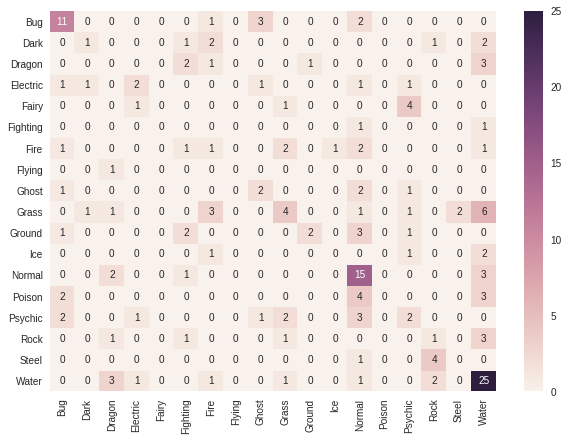

In [12]:
type1_categories = df_master['Type_1'].astype('category').cat.categories

df_cm = pd.DataFrame( metrics.confusion_matrix( y_test,  y_predict), index=type1_categories,
                    columns=type1_categories)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

As shown above, very few types were properly predicted by the simple logistic regression. Only 36% of the test set pokemon had their types correctly predicted, as indicated by the average recall of 0.36. Unsurprisingly, Bug, Normal and Water types were the best performing as they account for some of the most prevelant `Type_1` values.

**Can we do better?**

In [13]:
typeCount  = len(type1_categories)

typeColors = [ 'olivedrab', 'black', 'rebeccapurple', 'yellow', 'pink', 'firebrick', 'orangered',
             'powderblue', 'darkslateblue', 'green', 'peru', 'aquamarine', 'darkgray', 'purple',
              'fuchsia', 'tan', 'silver', 'c']

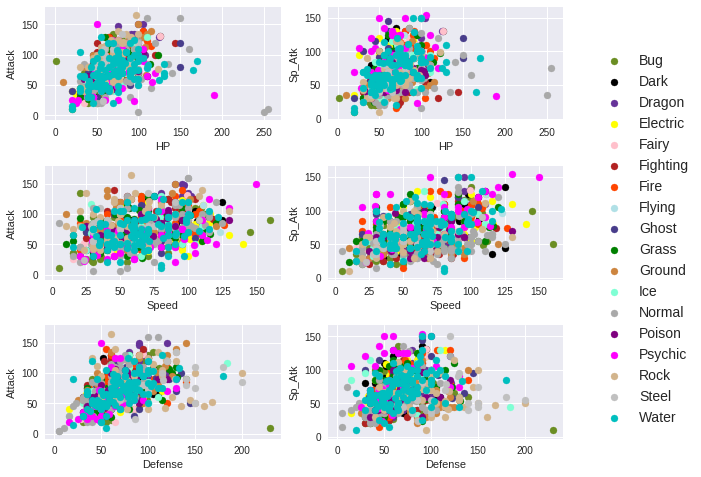

In [14]:
feature_x = [ 'HP', 'Speed', 'Defense']
feature_y = [ 'Attack', 'Sp_Atk']

fig = plt.figure()
fig.subplots_adjust(left=0, right=1.2, bottom=0, top=1.5, hspace=0.4, wspace=0.2)

i = 0
for x in feature_x:
    for y in feature_y:
        i += 1
        ax = fig.add_subplot( len(feature_x), len(feature_y), i)
        for label, color in zip( range(typeCount), typeColors):
            ax.scatter( df_master[ x][ df_master['Type_1']==type1_categories[label]], 
                        df_master[ y][ df_master['Type_1']==type1_categories[label]],
                        label=type1_categories[label],
                        c=color)

            ax.set_xlabel( x)
            ax.set_ylabel( y)


plt.legend( bbox_to_anchor=(1.1, 3.5), fontsize=14)

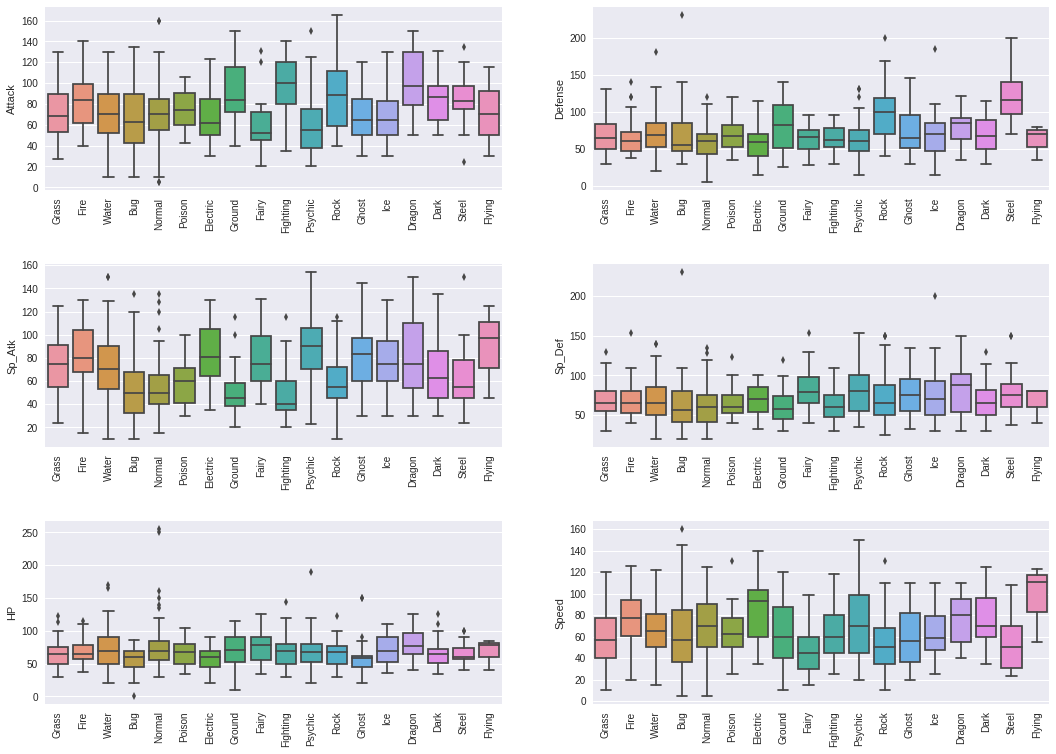

In [15]:
battleFeatures = [ 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'HP', 'Speed']

plt.figure( figsize=(18,27))
plt.subplots_adjust( hspace=0.4, wspace=0.2)     

for i, b in enumerate( battleFeatures):
        iSubFig = i + 1
        plt.subplot( 6, 2, iSubFig)
        sns.boxplot( x='Type_1', y=b, data=df_type)
        plt.xticks( rotation=90)
        plt.xlabel('')

## Battle Attribute Normalization

Let's normalize features `HP`, `Attack`, `Defense`, `Sp_Atk`, `Sp_Def`, `Speed` by the `Total`.

The motivation for this is that each different type pokemon usually have their battle attributes distributed differently. By using the ratio of the feature to the `Total` we can represent how it's `Total` is divided between all its attributes.

In [16]:
battleFeatures = [ 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'HP', 'Speed']

df_type['Total'] = df_type['Total'].astype('float64')

for b in battleFeatures:
    df_type[b] = df_type[b].astype('float64')
    df_type[b] = df_type[b] / df_type['Total']

In [17]:
df_type.head()

,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Color,hasGender,Egg_Group_1,Egg_Group_2,Height_m,Weight_kg,Catch_Rate,Body_Style
Number,,,,,,,,,,,,,,,,,,
1,Grass,Poison,318.0,0.141509,0.154088,0.154088,0.204403,0.204403,0.141509,1,3,True,10,6,0.71,6.9,45,9
2,Grass,Poison,405.0,0.148148,0.153086,0.155556,0.197531,0.197531,0.148148,1,3,True,10,6,0.99,13.0,45,9
3,Grass,Poison,525.0,0.152381,0.156190,0.158095,0.190476,0.190476,0.152381,1,3,True,10,6,2.01,100.0,45,9
4,Fire,NaN,309.0,0.126214,0.168285,0.139159,0.194175,0.161812,0.210356,1,7,True,10,2,0.61,8.5,45,0
5,Fire,NaN,405.0,0.143210,0.158025,0.143210,0.197531,0.160494,0.197531,1,7,True,10,2,1.09,19.0,45,0


Let's examine whether the  various Types have distinguishable difference in their feature values.

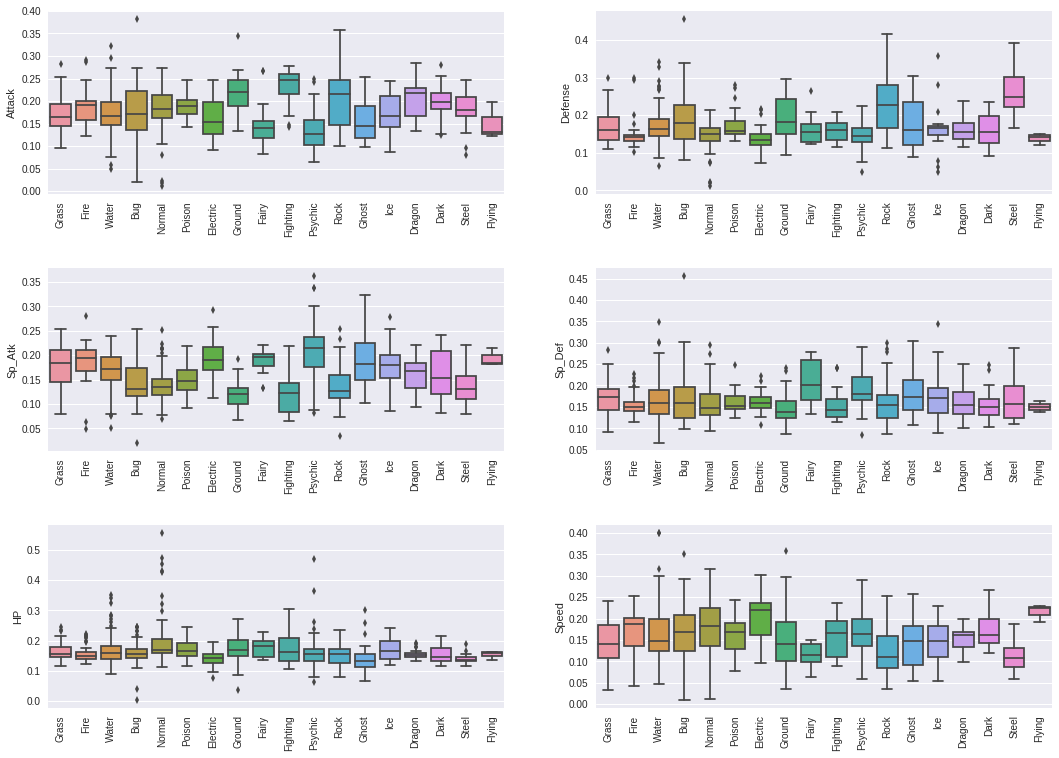

In [18]:
plt.figure( figsize=(18,27))
plt.subplots_adjust( hspace=0.4, wspace=0.2)     

for i, b in enumerate( battleFeatures):
        iSubFig = i + 1
        plt.subplot( 6, 2, iSubFig)
        sns.boxplot( x='Type_1', y=b, data=df_type)
        plt.xticks( rotation=90)
        plt.xlabel('')

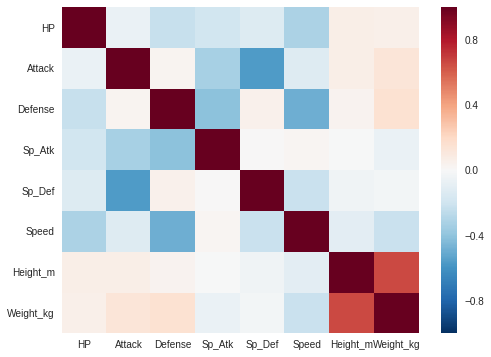

In [19]:
corr = df_type[['HP', 'Attack','Defense',
                'Sp_Atk', 'Sp_Def', 'Speed',
                'Height_m', 'Weight_kg']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Predict a specific type

Can we predict whether a pokemon is of a certain type?

Here we will examine if we can predict whether a pokemon is water type regardless of whether its the `Type_1` or `Type_2` feature.

We are going to focus on Water type since it is the most common pokemon type.

For this analysis, I want to be agnostic of the type order.
I also want to transform the categorical feautre values of `Type_1` and `Type_2` into numerical indicators. We will do this by first removing all the `NaN` values from the `Type_2` feature and then combining the two feature values together in order to make our dummy variable indicators.

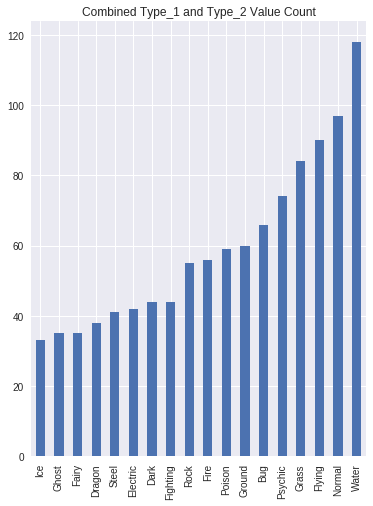

In [23]:
typeCombined = pd.Series( df_master[ 'Type_1'].value_counts() + df_master[ 'Type_2'].value_counts())
typeCombined = typeCombined.sort_values()
plt.figure( figsize=( 6, 8))
typeCombined.plot( kind='bar')
plt.title('Combined Type_1 and Type_2 Value Count')

In [25]:
df_water = df_type
df_water.Type_2.loc[ df_type['Type_2'].isnull() == True] = ''
typeSeries = df_water['Type_1'] + '|' + df_water['Type_2']
typeMatrix = typeSeries.str.get_dummies('|')

print 'Here is the list of binary type indicators:'
typeMatrix.head()

Here is the list of binary type indicators:


,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
Number,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [26]:
df_water = pd.merge( typeMatrix, df_water.drop([ 'Type_1', 'Type_2'], axis=1), left_index=True, right_index=True)
df_water = df_water.drop(['Grass', 'Fire', 'Flying', 'Bug', 'Normal',
                          'Poison', 'Electric', 'Ground', 'Fairy',
                          'Fighting', 'Psychic', 'Rock', 'Ghost',
                          'Ice', 'Dragon', 'Dark', 'Steel'], axis=1)

In [27]:
df_water.head()

,Water,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Color,hasGender,Egg_Group_1,Egg_Group_2,Height_m,Weight_kg,Catch_Rate,Body_Style
Number,,,,,,,,,,,,,,,,,
1,0,318.0,0.141509,0.154088,0.154088,0.204403,0.204403,0.141509,1,3,True,10,6,0.71,6.9,45,9
2,0,405.0,0.148148,0.153086,0.155556,0.197531,0.197531,0.148148,1,3,True,10,6,0.99,13.0,45,9
3,0,525.0,0.152381,0.156190,0.158095,0.190476,0.190476,0.152381,1,3,True,10,6,2.01,100.0,45,9
4,0,309.0,0.126214,0.168285,0.139159,0.194175,0.161812,0.210356,1,7,True,10,2,0.61,8.5,45,0
5,0,405.0,0.143210,0.158025,0.143210,0.197531,0.160494,0.197531,1,7,True,10,2,1.09,19.0,45,0


In [28]:
columnIndex = df_water.columns
features    = df_water[ columnIndex[1:]]
typeWater  = df_water['Water']

In [29]:
clf_log = LogisticRegression( C=0.1)

X_train, X_test, y_train, y_test = train_test_split( features, typeWater, test_size=0.25, random_state=10)

clf_log.fit( X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
y_predict = clf_log.predict( X_test)

In [31]:
print 'Summary metrics for Logistic Regression: \n %s' \
        % metrics.classification_report( y_test, y_predict)

Summary metrics for Logistic Regression: 
              precision    recall  f1-score   support

          0       0.93      0.98      0.95       148
          1       0.88      0.67      0.76        33

avg / total       0.92      0.92      0.92       181



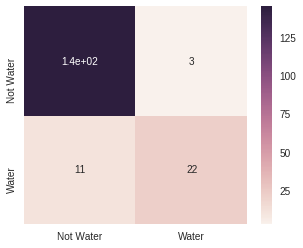

In [32]:
type1_categories = df_master['Type_1'].astype('category').cat.categories

df_cm = pd.DataFrame( metrics.confusion_matrix( y_test,  y_predict),
                     index=[ 'Not Water', 'Water'], columns=[ 'Not Water', 'Water'])
plt.figure(figsize = (5,4))
sns.heatmap(df_cm, annot=True)

Not bad for a first pass! The classifier accurately predicts water types two thirds of the time.

In [21]:
from sklearn.svm import SVC

Summary metrics for Logistic Regression: 
              precision    recall  f1-score   support

          0       0.82      1.00      0.90       148
          1       0.00      0.00      0.00        33

avg / total       0.67      0.82      0.74       181



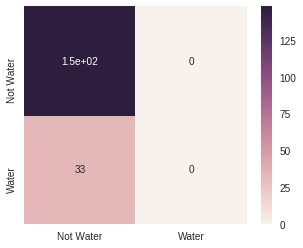

In [33]:
clf_svm = SVC()
clf_svm.fit( X_train, y_train)
y_predict = clf_svm.predict( X_test)

print 'Summary metrics for Logistic Regression: \n %s' \
        % metrics.classification_report( y_test, y_predict)

    
type1_categories = df_master['Type_1'].astype('category').cat.categories

df_cm = pd.DataFrame( metrics.confusion_matrix( y_test,  y_predict),
                     index=[ 'Not Water', 'Water'], columns=[ 'Not Water', 'Water'])
plt.figure(figsize = (5,4))
sns.heatmap(df_cm, annot=True)

## Making a pipeline

In [56]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [44]:
# create estimators
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('clfLog', LogisticRegression()))
model = Pipeline(estimators)

In [45]:
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, features, typeWater, cv=kfold)
print(results.mean())

0.915410958904


In [57]:
# gridsearch
pipe = Pipeline( steps=[( 'clfLog', LogisticRegression())] )

In [65]:
estimator = GridSearchCV( pipe,
                         dict( clfLog__C=np.logspace(-4, 4, 5)) )

In [66]:
estimator.fit( features, typeWater)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('clfLog', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clfLog__C': array([  1.00000e-04,   1.00000e-02,   1.00000e+00,   1.00000e+02,
         1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [70]:
sorted(estimator.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_clfLog__C',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [85]:
estimator.best_estimator_.named_steps['clfLog'].coef_

array([[  2.55138935e-03,  -2.52963763e-01,  -7.27821014e+00,
         -2.88890693e+00,   3.68609055e+00,  -3.84043846e+00,
          2.10726719e+00,  -3.57234311e-02,  -2.09762603e-01,
          8.48902786e-01,   6.57321913e-01,   2.33809326e-01,
          1.19398359e-01,  -2.36854528e-03,   4.20147153e-03,
          8.35626984e-02]])

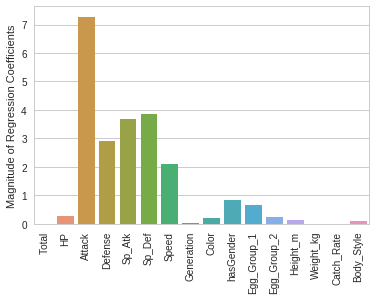

In [102]:
clfLog_coef = estimator.best_estimator_.named_steps['clfLog'].coef_[0]
features.columns
sns.set_style("whitegrid")
sns.barplot( x=features.columns, y=abs(clfLog_coef))
plt.xticks(rotation=90);
plt.ylabel('Magnitude of Regression Coefficients')